# Preparation of Dataset (development notebook)

## Import section

In [1]:
import numpy as np
import pandas as pd

from etnn.data.prepare_ferris_wheel import prepare_1_ferris, generate_ferris_dataset, add_valid_permutations, \
    sample_new_permutations
from etnn.data.ferris_score_helpers import build_wheel_happyness
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset, load_modified_ferris_wheel_dataset
import torch
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm

from etnn.tools.loader import create_sampler

In [2]:
DATASET_PATH = "../datasets"

## Person dataset

In [3]:
df_health = prepare_1_ferris(
    dataset_path="../datasets",
    df_name_output="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True
)

In [4]:
df_health.head()

,id,age,occupation,sleep_duration,sleep_quality,physical_activity,stress_level,bmi,heart_rate,daily_steps,sleep_disorder,blood_pressure1,blood_pressure2,gender_male,gender_female,gender_other
0,1,27,1,6.1,6,42,6,2,77,4200,0,126,83,True,False,False
1,2,28,2,6.2,6,60,8,0,75,10000,0,125,80,True,False,False
2,3,28,2,6.2,6,60,8,0,75,10000,0,125,80,True,False,False
3,4,28,3,5.9,4,30,8,3,85,3000,1,140,90,True,False,False
4,5,28,3,5.9,4,30,8,3,85,3000,1,140,90,True,False,False


## Gondola dataset (indexing)

In [5]:
# take group of ids from persons and state how the label for this group shall be calculated

In [6]:
# define ferris wheel
num_gondolas = 10
num_part_pg = 5

In [7]:
# generate sample element
random_order = np.arange(len(df_health)) + 1
np.random.shuffle(random_order)

In [8]:
example = [
    random_order[i*num_part_pg:(i+1)*num_part_pg]
    for i in range(num_gondolas)
]

In [9]:
example

[array([363, 235, 309,  10,  54]),
 array([295, 143, 147,  84,  70]),
 array([311, 193, 308, 192, 353]),
 array([359, 188, 331, 206, 101]),
 array([ 18, 362, 352, 307, 130]),
 array([ 74, 368, 270, 154, 259]),
 array([104, 141, 324, 171,  37]),
 array([191, 245, 278,  61, 252]),
 array([117, 249, 322,  17, 184]),
 array([246, 203, 268,  89,  79])]

In [10]:
random_order[:num_gondolas*num_part_pg].reshape(num_gondolas, num_part_pg)

array([[363, 235, 309,  10,  54],
       [295, 143, 147,  84,  70],
       [311, 193, 308, 192, 353],
       [359, 188, 331, 206, 101],
       [ 18, 362, 352, 307, 130],
       [ 74, 368, 270, 154, 259],
       [104, 141, 324, 171,  37],
       [191, 245, 278,  61, 252],
       [117, 249, 322,  17, 184],
       [246, 203, 268,  89,  79]])

Rules:
- People being happy with other people in same gondola
    + Age composition too seperated is bad
    + shift in gender is bad if too much, 50-50 is good or all one gender
    + same with age composition
    + sleep derived(multiplier with quality) persons get a subtraction and 'good sleepers' get bonus (sleep disorder counts as stronger subtraction)
    + higher heart rate and pressure = joy or fear
    + composition of persons in regards to bmi : extreme values make others (no exception for group all those as to many underweight or overweight persons may be awquard as well)
- People being happy with neighboring gondolas composition
    + same age gets bonus, none gets penalty as potentially group is separated
    + gap between happyness index between self and neighbors causes it to produce a mean of only the neighbors

In [11]:
build_wheel_happyness(df_health, example)

56.82114666666667

In [12]:
build_wheel_happyness(df_health, random_order[:num_gondolas * num_part_pg].reshape(num_gondolas, num_part_pg))

56.82114666666667

In [13]:
# define dataset size
num_to_generate = 10_000
# define ferris wheel
num_gondolas = 10
num_part_pg = 5

In [14]:
df_index, df_health = generate_ferris_dataset(
    num_gondolas=num_gondolas,
    num_part_pg=num_part_pg,
    num_to_generate=num_to_generate,
    dataset_path="../datasets",
    df_intermediate_output_name="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True
)

In [15]:
df_index.head()

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
0,264,191,98,235,35,356,253,9,147,311,...,315,265,92,23,287,17,234,223,117,68.011480
1,338,176,95,11,161,248,364,53,64,71,...,181,365,96,187,165,38,114,98,56,55.463373
2,290,99,75,21,237,287,215,213,172,214,...,76,188,274,77,264,117,254,168,65,66.108493
3,15,277,93,106,290,354,60,226,75,318,...,243,288,74,131,344,86,266,218,83,58.642507
4,190,260,34,286,360,167,251,298,256,15,...,48,258,107,5,307,121,162,7,37,62.584213


In [16]:
df_health.head()

,id,age,occupation,sleep_duration,sleep_quality,physical_activity,stress_level,bmi,heart_rate,daily_steps,sleep_disorder,blood_pressure1,blood_pressure2,gender_male,gender_female,gender_other
0,1,27,1,6.1,6,42,6,2,77,4200,0,126,83,True,False,False
1,2,28,2,6.2,6,60,8,0,75,10000,0,125,80,True,False,False
2,3,28,2,6.2,6,60,8,0,75,10000,0,125,80,True,False,False
3,4,28,3,5.9,4,30,8,3,85,3000,1,140,90,True,False,False
4,5,28,3,5.9,4,30,8,3,85,3000,1,140,90,True,False,False


In [17]:
df_index.iloc[:, :-1]

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-0,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4
0,264,191,98,235,35,356,253,9,147,311,...,299,315,265,92,23,287,17,234,223,117
1,338,176,95,11,161,248,364,53,64,71,...,100,181,365,96,187,165,38,114,98,56
2,290,99,75,21,237,287,215,213,172,214,...,122,76,188,274,77,264,117,254,168,65
3,15,277,93,106,290,354,60,226,75,318,...,235,243,288,74,131,344,86,266,218,83
4,190,260,34,286,360,167,251,298,256,15,...,28,48,258,107,5,307,121,162,7,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,127,84,110,152,265,90,318,72,331,237,...,346,7,341,126,70,208,67,248,291,246
9996,286,97,191,288,32,268,41,347,272,169,...,194,178,269,310,79,370,108,189,340,24
9997,372,168,198,199,239,369,323,277,174,281,...,191,112,75,331,177,163,155,7,188,290
9998,154,310,224,59,87,207,97,78,290,241,...,12,338,254,183,145,22,95,247,158,231


## Total dataset creation

In [18]:
dataset = load_pure_ferris_wheel_dataset(
    num_gondolas=num_gondolas,
    num_part_pg=num_part_pg,
    num_to_generate=num_to_generate,
    dataset_path="../datasets",
    df_intermediate_output_name="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True
)

In [19]:
dataset[0]

(tensor([[4.5000e+01, 1.1000e+01, 6.9000e+00, 7.0000e+00, 5.5000e+01, 5.0000e+00,
          2.0000e+00, 7.5000e+01, 5.5000e+03, 0.0000e+00, 1.2500e+02, 8.2000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [4.3000e+01, 4.0000e+00, 6.7000e+00, 7.0000e+00, 4.5000e+01, 4.0000e+00,
          2.0000e+00, 6.5000e+01, 6.0000e+03, 2.0000e+00, 1.3500e+02, 9.0000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [3.6000e+01, 7.0000e+00, 7.1000e+00, 8.0000e+00, 6.0000e+01, 4.0000e+00,
          0.0000e+00, 6.8000e+01, 7.0000e+03, 0.0000e+00, 1.1500e+02, 7.5000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [4.4000e+01, 4.0000e+00, 6.6000e+00, 7.0000e+00, 4.5000e+01, 4.0000e+00,
          2.0000e+00, 6.5000e+01, 6.0000e+03, 2.0000e+00, 1.3500e+02, 9.0000e+01,
          0.0000e+00, 1.0000e+00, 0.0000e+00],
         [3.1000e+01, 2.0000e+00, 7.7000e+00, 7.0000e+00, 7.5000e+01, 6.0000e+00,
          0.0000e+00, 7.0000e+01, 8.0000e+03, 0.0000e+00, 1.2000e+02, 8.00

## DataLoaders

In [20]:
generator = torch.Generator().manual_seed(420)
train_ds, val_ds, test_ds = random_split(dataset, [0.7, 0.1, 0.2], generator=generator)

In [21]:
train_ds

In [22]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [23]:
for x, y in train_loader:
    print(f"x-shape:{x.shape}, y-shape:{y.shape}")
    break

x-shape:torch.Size([32, 50, 15]), y-shape:torch.Size([32])


## Specialize pure datasets

In [24]:
df_added_valid = add_valid_permutations(
    num_to_generate,
    df_index,
    num_gondolas
)

100%|██████████| 10000/10000 [00:00<00:00, 29156.04it/s]


In [25]:
df_added_valid

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
0,264,191,98,235,35,356,253,9,147,311,...,315,265,92,23,287,17,234,223,117,68.011480
1,338,176,95,11,161,248,364,53,64,71,...,181,365,96,187,165,38,114,98,56,55.463373
2,290,99,75,21,237,287,215,213,172,214,...,76,188,274,77,264,117,254,168,65,66.108493
3,15,277,93,106,290,354,60,226,75,318,...,243,288,74,131,344,86,266,218,83,58.642507
4,190,260,34,286,360,167,251,298,256,15,...,48,258,107,5,307,121,162,7,37,62.584213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,14,204,272,195,136,217,178,137,46,197,...,263,94,345,248,227,6,102,127,301,59.765280
19996,278,282,328,303,251,265,25,243,199,365,...,342,188,40,77,39,358,34,290,335,71.027800
19997,169,160,69,298,314,234,346,350,246,338,...,173,73,277,286,70,17,180,118,137,71.582987
19998,26,358,181,46,355,83,54,366,125,155,...,277,174,80,106,260,342,194,287,371,57.986000


In [26]:
dataset = load_modified_ferris_wheel_dataset(
    num_gondolas=num_gondolas,
    num_part_pg=num_part_pg,
    num_to_generate=num_to_generate,
    num_valid_to_add=num_to_generate,
    dataset_path="../datasets",
    df_intermediate_output_name="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True
)

## Change regression task to classification

In [27]:
temp = df_index.label/(10*num_gondolas)*10

In [28]:
temp.round()

0       7.0
1       6.0
2       7.0
3       6.0
4       6.0
       ... 
9995    6.0
9996    6.0
9997    7.0
9998    7.0
9999    5.0
Name: label, Length: 10000, dtype: float64

## Problem: dataset too centered around a specific value

In [29]:
df_index.label.describe()

count    10000.000000
mean        63.529537
std          5.500780
min         48.837187
25%         59.621903
50%         63.253673
75%         66.986460
max         90.799333
Name: label, dtype: float64

<Axes: >

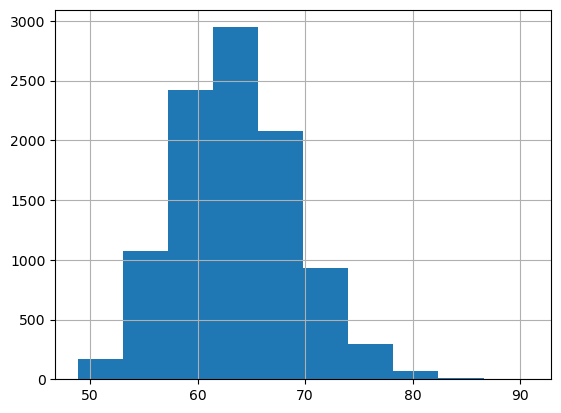

In [30]:
df_index.label.hist()

In [31]:
df_downsample = df_index.copy(deep=True)
df_downsample

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
0,264,191,98,235,35,356,253,9,147,311,...,315,265,92,23,287,17,234,223,117,68.011480
1,338,176,95,11,161,248,364,53,64,71,...,181,365,96,187,165,38,114,98,56,55.463373
2,290,99,75,21,237,287,215,213,172,214,...,76,188,274,77,264,117,254,168,65,66.108493
3,15,277,93,106,290,354,60,226,75,318,...,243,288,74,131,344,86,266,218,83,58.642507
4,190,260,34,286,360,167,251,298,256,15,...,48,258,107,5,307,121,162,7,37,62.584213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,127,84,110,152,265,90,318,72,331,237,...,7,341,126,70,208,67,248,291,246,63.678893
9996,286,97,191,288,32,268,41,347,272,169,...,178,269,310,79,370,108,189,340,24,55.686920
9997,372,168,198,199,239,369,323,277,174,281,...,112,75,331,177,163,155,7,188,290,66.045467
9998,154,310,224,59,87,207,97,78,290,241,...,338,254,183,145,22,95,247,158,231,72.811613


In [32]:
df_downsample['label_cat'] = (df_downsample.label/5).round()

In [33]:
df_downsample

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label,label_cat
0,264,191,98,235,35,356,253,9,147,311,...,265,92,23,287,17,234,223,117,68.011480,14.0
1,338,176,95,11,161,248,364,53,64,71,...,365,96,187,165,38,114,98,56,55.463373,11.0
2,290,99,75,21,237,287,215,213,172,214,...,188,274,77,264,117,254,168,65,66.108493,13.0
3,15,277,93,106,290,354,60,226,75,318,...,288,74,131,344,86,266,218,83,58.642507,12.0
4,190,260,34,286,360,167,251,298,256,15,...,258,107,5,307,121,162,7,37,62.584213,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,127,84,110,152,265,90,318,72,331,237,...,341,126,70,208,67,248,291,246,63.678893,13.0
9996,286,97,191,288,32,268,41,347,272,169,...,269,310,79,370,108,189,340,24,55.686920,11.0
9997,372,168,198,199,239,369,323,277,174,281,...,75,331,177,163,155,7,188,290,66.045467,13.0
9998,154,310,224,59,87,207,97,78,290,241,...,254,183,145,22,95,247,158,231,72.811613,15.0


In [34]:
n_samples = df_downsample.groupby('label_cat').size().min()
n_samples

1

In [35]:
downsampled_df = df_downsample.groupby('label_cat').apply(lambda x: x.sample(min(len(x), 10)))
downsampled_df

g-0_p-0  g-0_p-1  g-0_p-2  g-0_p-3  g-0_p-4  g-1_p-0  g-1_p-1  \
label_cat                                                                       
10.0      8158      176       74      113      170       94       66      187   
          9804      364       19       44      335      190      242      146   
          2343      277       13      224      306      307      295      293   
          5570      374      265      151       60      367       54      229   
          6361      351      125        3      191       71       67        6   
...                 ...      ...      ...      ...      ...      ...      ...   
17.0      3558       24      134       52      183       42       34      122   
          1733       91      101      360      134       87      188      163   
          5103      200      247      181       49      260      342      156   
          2424      106        4      199      269      110       98      129   
18.0      7641      314      150       39      307       47      114      287   

                g-1_p-2  g-1_p-3  g-1_p-4  ...  g-8_p-2  g-8_p-3  g-8_p-4  \
label_cat                                  ...                              
10.0      8158      283      152      116  ...      339      362      111   
          9804       63      132      143  ...      110      119      215   
          2343        3      333      111  ...      292      118      215   
          5570      277      162        4  ...      341       31      146   
          6361      214      246       20  ...       36      238      341   
...                 ...      ...      ...  ...      ...      ...      ...   
17.0      3558      143       85      137  ...      123       79      326   
          1733       70       26       85  ...      109       75      223   
          5103      340      227      287  ...      186       64      353   
          2424        7      203      241  ...      163      234      164   
18.0      7641       61      112      247  ...      260      232      107   

                g-9_p-0  g-9_p-1  g-9_p-2  g-9_p-3  g-9_p-4      label  \
label_cat                                                                
10.0      8158      234      242      123      214      148  51.405973   
          9804      168      136      348      333      250  52.429067   
          2343      145      231      348      161       49  51.966147   
          5570      272      245      369       43      140  50.780053   
          6361      335      111       61       94      151  50.790893   
...                 ...      ...      ...      ...      ...        ...   
17.0      3558      176       55       50      125       30  84.566170   
          1733       22      130      350       61      117  84.667533   
          5103       51      109      112       84      241  82.867680   
          2424       71       32      179      231      244  85.504837   
18.0      7641      127      102       43      188      258  90.799333   

                label_cat  
label_cat                  
10.0      8158       10.0  
          9804       10.0  
          2343       10.0  
          5570       10.0  
          6361       10.0  
...                   ...  
17.0      3558       17.0  
          1733       17.0  
          5103       17.0  
          2424       17.0  
18.0      7641       18.0  

[76 rows x 52 columns]

In [36]:
downsampled_df.label.describe()

count    76.000000
mean     66.639625
std      10.500593
min      50.596480
25%      57.242400
50%      66.172760
75%      74.905291
max      90.799333
Name: label, dtype: float64

# Make weighted random sampler to easy distribution problems

In [37]:
sampler = create_sampler(
    df_index=df_index,
    dataset=None
)

In [38]:
selection = list(sampler)
print(selection)
labels_here = [df_index.iloc[idx].label for idx in selection]
print(labels_here)

[3742, 9881, 990, 5515, 7385, 4438, 330, 3451, 1662, 2375, 553, 4293, 9073, 4511, 9736, 3123, 2573, 4755, 8702, 6643, 4057, 6581, 7641, 5007, 8812, 5900, 7817, 6955, 9456, 911, 819, 2776, 9091, 7949, 1853, 7289, 3819, 7641, 45, 5702, 4119, 5691, 1489, 7683, 3780, 7682, 4612, 1771, 7785, 7641, 9101, 3029, 4028, 2280, 5429, 5548, 7664, 5691, 1541, 9648, 4824, 2539, 1811, 8742, 1239, 7580, 2410, 911, 7677, 59, 9190, 2306, 7337, 3679, 6246, 3262, 8311, 3034, 6834, 7215, 4533, 1936, 3558, 9809, 7641, 3644, 6354, 4020, 7919, 7010, 6009, 4473, 3558, 5103, 93, 8533, 5674, 5691, 7951, 6569, 2590, 5675, 4720, 7897, 3553, 7996, 2249, 2255, 7311, 2424, 4493, 3887, 3558, 4035, 4519, 7545, 5435, 5611, 4339, 6328, 5026, 2424, 3059, 82, 3558, 1530, 6094, 7301, 495, 6850, 452, 4313, 1733, 187, 9032, 7641, 9929, 5940, 1080, 4414, 4313, 8448, 1440, 4986, 2693, 5103, 1179, 2253, 59, 3558, 338, 265, 5935, 8726, 355, 2723, 3398, 9364, 2181, 6892, 3572, 4285, 5103, 9071, 5572, 4984, 2711, 1731, 7568, 4237, 4

In [39]:
df_training = pd.DataFrame(list(sampler), columns=['idx'])
df_training

,idx
0,1733
1,1304
2,6518
3,9224
4,6163
...,...
9995,3558
9996,748
9997,7347
9998,1224


In [40]:
df_training['labels'] = df_training.idx.map(lambda x: df_index.iloc[x].label)

In [41]:
df_training

,idx,labels
0,1733,84.667533
1,1304,67.618053
2,6518,62.738280
3,9224,55.090267
4,6163,78.171533
...,...,...
9995,3558,84.566170
9996,748,59.803933
9997,7347,52.692453
9998,1224,61.257920


In [42]:
df_training.labels.describe()

count    10000.000000
mean        67.914206
std         11.385108
min         48.837187
25%         58.189503
50%         67.743293
75%         77.615487
max         90.799333
Name: labels, dtype: float64

<Axes: >

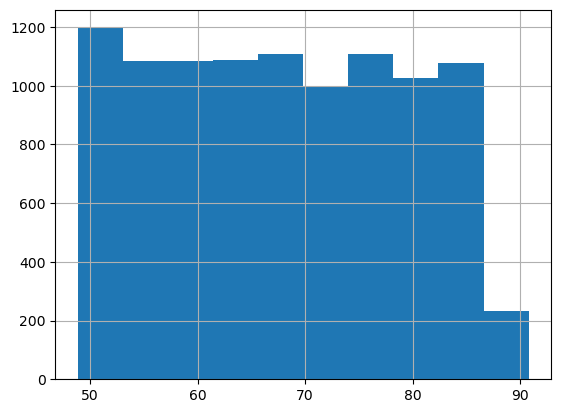

In [43]:
df_training.labels.hist()

In [45]:
train_sampler = create_sampler(df_index, train_ds)

In [46]:
train_loader_equal = DataLoader(train_ds, batch_size=64, sampler=train_sampler)

In [47]:
for _, y in train_loader_equal:
    print(y)
    print(f"mean: {y.mean()}, std: {y.std()}, min:{y.min()}, max:{y.max()}")
    break

tensor([79.9804, 56.2746, 63.1527, 84.5662, 64.5328, 78.8448, 58.0579, 50.3900,
        83.9287, 74.7397, 84.5662, 78.1771, 52.2869, 74.7927, 56.7302, 53.6750,
        80.9042, 79.6387, 79.9700, 56.5371, 64.0149, 63.0506, 66.6949, 54.1067,
        83.9287, 76.7201, 76.4998, 82.8677, 55.1358, 59.9988, 74.3701, 72.4696,
        49.9649, 81.2339, 62.1700, 60.6257, 59.0268, 56.0078, 84.5662, 49.0326,
        61.2665, 76.3776, 75.4866, 82.4980, 81.3345, 53.0603, 72.2300, 77.9569,
        81.0577, 64.1820, 71.7761, 57.1892, 77.2995, 75.0246, 71.4701, 78.6084,
        63.3626, 59.4119, 81.6662, 58.8737, 80.3524, 65.9337, 63.7118, 78.6198])
mean: 69.26533508300781, std: 10.997418403625488, min:49.03255844116211, max:84.56616973876953


In [59]:
df_temp = df_index.iloc[train_ds.indices]
df_temp

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label,rounded_label,label_weights
8881,41,74,187,246,180,280,301,298,96,83,...,80,58,278,228,160,106,126,67.868893,68.0,23.041475
5876,282,363,117,180,372,60,82,26,184,53,...,242,28,351,370,207,149,151,63.981707,64.0,14.367816
1172,128,54,170,252,27,154,310,38,354,298,...,30,7,174,145,22,18,322,65.956680,66.0,15.432099
7787,282,130,57,211,256,64,25,243,344,19,...,62,144,4,199,259,73,153,62.298733,62.0,13.531800
8951,37,32,13,118,136,129,281,256,112,363,...,62,303,340,188,149,309,298,61.945040,62.0,13.531800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5765,84,209,78,185,259,258,40,217,148,90,...,62,238,200,47,231,345,69,66.911693,67.0,17.667845
6050,241,53,114,39,16,204,26,297,266,232,...,21,259,299,216,140,300,88,66.280320,66.0,15.432099
7765,164,104,15,3,11,121,373,6,262,34,...,75,205,347,358,251,179,371,65.218920,65.0,14.204545
7296,129,264,321,71,218,58,344,252,148,339,...,295,149,309,89,70,245,350,54.193333,54.0,51.282051


In [60]:
df_temp.iloc[0]

g-0_p-0           41.000000
g-0_p-1           74.000000
g-0_p-2          187.000000
g-0_p-3          246.000000
g-0_p-4          180.000000
g-1_p-0          280.000000
g-1_p-1          301.000000
g-1_p-2          298.000000
g-1_p-3           96.000000
g-1_p-4           83.000000
g-2_p-0            3.000000
g-2_p-1          109.000000
g-2_p-2          164.000000
g-2_p-3          257.000000
g-2_p-4           33.000000
g-3_p-0          253.000000
g-3_p-1          211.000000
g-3_p-2          208.000000
g-3_p-3           54.000000
g-3_p-4          217.000000
g-4_p-0          314.000000
g-4_p-1           84.000000
g-4_p-2            4.000000
g-4_p-3          357.000000
g-4_p-4          266.000000
g-5_p-0           63.000000
g-5_p-1          185.000000
g-5_p-2          213.000000
g-5_p-3          114.000000
g-5_p-4          233.000000
g-6_p-0          130.000000
g-6_p-1          159.000000
g-6_p-2          365.000000
g-6_p-3          241.000000
g-6_p-4          209.000000
g-7_p-0          361

# Generate complete dataset

In [48]:
from itertools import permutations

In [49]:
list(permutations(range(3), 2))

[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]

In [50]:
num_gondolas = 10
num_part_pg = 5

In [51]:
n_persons = 374

In [52]:
# create all combinations
all_perms = permutations(range(1, n_persons + 1), num_gondolas*num_part_pg)

Wait... way too large! this has over 10^89 possibilities - scrap this

# Generation of testset

In [53]:
# idea: want to generate elements that are valid permutations and are not in the training set
df_index, df_health = generate_ferris_dataset(
    num_gondolas=num_gondolas,
    num_part_pg=num_part_pg,
    num_to_generate=num_to_generate,
    dataset_path="../datasets",
    df_intermediate_output_name="health_dataset_preprocessed-1.csv",
    df_name_input="Sleep_health_and_lifestyle_dataset.csv",
    try_pregen=True
)

In [54]:
df_index

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
0,264,191,98,235,35,356,253,9,147,311,...,315,265,92,23,287,17,234,223,117,68.011480
1,338,176,95,11,161,248,364,53,64,71,...,181,365,96,187,165,38,114,98,56,55.463373
2,290,99,75,21,237,287,215,213,172,214,...,76,188,274,77,264,117,254,168,65,66.108493
3,15,277,93,106,290,354,60,226,75,318,...,243,288,74,131,344,86,266,218,83,58.642507
4,190,260,34,286,360,167,251,298,256,15,...,48,258,107,5,307,121,162,7,37,62.584213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,127,84,110,152,265,90,318,72,331,237,...,7,341,126,70,208,67,248,291,246,63.678893
9996,286,97,191,288,32,268,41,347,272,169,...,178,269,310,79,370,108,189,340,24,55.686920
9997,372,168,198,199,239,369,323,277,174,281,...,112,75,331,177,163,155,7,188,290,66.045467
9998,154,310,224,59,87,207,97,78,290,241,...,338,254,183,145,22,95,247,158,231,72.811613


In [55]:
df_test = sample_new_permutations(
    df_index=df_index,
    num_gondolas=num_gondolas,
    num_elem=10,
    merge_check=True
)

100%|██████████| 10/10 [00:00<00:00, 9998.34it/s]


In [56]:
df_test

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
0,4,268,174,238,70,273,27,9,18,243,...,252,373,60,168,41,159,330,346,244,59.592960
1,242,276,303,374,300,28,27,2,324,230,...,245,268,78,117,57,128,191,92,85,70.864360
2,272,1,339,194,129,147,280,85,321,351,...,219,228,340,316,245,289,10,299,106,58.385373
3,283,246,230,158,11,170,162,237,38,101,...,25,145,287,281,191,79,63,27,81,57.203640
4,371,290,60,23,44,208,347,56,177,143,...,120,215,366,368,151,361,333,89,95,56.395627
5,63,230,282,277,4,77,224,244,40,33,...,221,89,116,245,247,82,226,322,170,68.696147
6,63,259,151,221,189,98,85,99,62,139,...,358,168,50,121,298,107,36,158,91,77.823420
7,286,220,245,108,150,306,40,24,368,369,...,212,185,210,328,238,190,359,341,228,69.680560
8,143,358,239,366,149,61,267,255,222,223,...,49,169,199,259,5,92,130,11,98,56.106613
9,86,197,36,240,62,143,238,282,306,348,...,33,253,302,58,203,99,147,225,305,63.063280


In [57]:
df_test2 = df_index.iloc[-10:]
df_test2

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-1,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label
9990,106,45,228,126,234,246,89,105,243,344,...,130,87,167,310,217,146,21,54,317,61.771467
9991,324,53,301,257,20,48,316,73,319,184,...,138,195,237,11,7,291,221,249,272,62.655867
9992,284,346,238,179,80,22,190,123,17,242,...,71,265,347,186,191,37,78,234,320,64.899493
9993,123,261,272,361,15,8,346,89,281,242,...,99,371,32,144,55,178,60,17,319,57.060120
9994,146,13,58,171,90,4,24,31,187,185,...,86,205,244,196,222,29,295,199,137,59.295680
9995,127,84,110,152,265,90,318,72,331,237,...,7,341,126,70,208,67,248,291,246,63.678893
9996,286,97,191,288,32,268,41,347,272,169,...,178,269,310,79,370,108,189,340,24,55.686920
9997,372,168,198,199,239,369,323,277,174,281,...,112,75,331,177,163,155,7,188,290,66.045467
9998,154,310,224,59,87,207,97,78,290,241,...,338,254,183,145,22,95,247,158,231,72.811613
9999,351,31,277,304,357,35,111,254,40,69,...,71,65,163,296,123,363,180,148,297,53.813760


In [58]:
merged = df_test2.merge(df_index, how='left', indicator=True)

In [59]:
merged

,g-0_p-0,g-0_p-1,g-0_p-2,g-0_p-3,g-0_p-4,g-1_p-0,g-1_p-1,g-1_p-2,g-1_p-3,g-1_p-4,...,g-8_p-2,g-8_p-3,g-8_p-4,g-9_p-0,g-9_p-1,g-9_p-2,g-9_p-3,g-9_p-4,label,_merge
0,106,45,228,126,234,246,89,105,243,344,...,87,167,310,217,146,21,54,317,61.771467,both
1,324,53,301,257,20,48,316,73,319,184,...,195,237,11,7,291,221,249,272,62.655867,both
2,284,346,238,179,80,22,190,123,17,242,...,265,347,186,191,37,78,234,320,64.899493,both
3,123,261,272,361,15,8,346,89,281,242,...,371,32,144,55,178,60,17,319,57.060120,both
4,146,13,58,171,90,4,24,31,187,185,...,205,244,196,222,29,295,199,137,59.295680,both
5,127,84,110,152,265,90,318,72,331,237,...,341,126,70,208,67,248,291,246,63.678893,both
6,286,97,191,288,32,268,41,347,272,169,...,269,310,79,370,108,189,340,24,55.686920,both
7,372,168,198,199,239,369,323,277,174,281,...,75,331,177,163,155,7,188,290,66.045467,both
8,154,310,224,59,87,207,97,78,290,241,...,254,183,145,22,95,247,158,231,72.811613,both
9,351,31,277,304,357,35,111,254,40,69,...,65,163,296,123,363,180,148,297,53.813760,both


In [60]:
sum(merged['_merge'] == 'both')

10

In [61]:
merged._merge

0    both
1    both
2    both
3    both
4    both
5    both
6    both
7    both
8    both
9    both
Name: _merge, dtype: category
Categories (3, object): ['left_only', 'right_only', 'both']